<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/L7_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)

Good visual explonation: https://poloclub.github.io/cnn-explainer/

In [106]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchvision.transforms import ToTensor
from timeit import default_timer as timer
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


In [107]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [108]:
# Utils
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def print_train_time(
    start: float,
    end: float,
    device: torch.device = device):
  """ Print the difference between sthe start and the end time """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


def eval_model(model:torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  """ Return a dictionary containing the results of the model predictions """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the avarage loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {
      "model_name": model.__class__.__name__, # This only work for model created with a class
      "model_loss": loss.item(),
      "model_acc": acc
      }

def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device
):

  """ Perform the trining speps on the data_loader """

  # Training
  train_loss, train_acc = 0, 0
  model.train()

  # Train on batches
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print(f"Batch: {batch} | Train loss: {train_loss/len(data_loader):.4f} | Train acc: {train_acc/len(data_loader):.4f}")

  # calculate loss / epoch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  if batch % 400 == 0:
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}%")

def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device
):

  """ Perform a testing on model with test data_loader """

  # testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y , y_pred = test_pred.argmax(dim=1)) # test_pred.argmax(dim=1) get the highest value INDEX

    # calculate accuracy and loss / test batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}% \n")

In [109]:
train_data = datasets.FashionMNIST(
  root="data", # where to download it
  train=True, # do we want the training data set
  transform=ToTensor(), # transform it
  download=True, # download or not?
  target_transform=None # keep the labels as it is
)

test_data = datasets.FashionMNIST(
  root="data",
  train=False,
  transform=ToTensor(),
  download=True,
  target_transform=None # keep the labels as it is
)

In [110]:
# class names AKA the labels
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [111]:
# map the classes to labels
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [112]:
# Set up hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 3
LEARNING_RATE = 0.1
RANDOM_SEED = 42
INPUT_SHAPE = (1, 28, 28)
OUTPUT_SHAPE = len(class_names) # dynamicly assigne to the class names
HIDDEN_UNITS = 128
DROPOUT_RATE = 0.2

In [113]:
# Prepare DataLoder

train_dataloader = torch.utils.data.DataLoader(
  dataset=train_data,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=1,
  pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
  dataset=test_data,
  batch_size=BATCH_SIZE,
  shuffle=False, # keep it in order, better for testing
  num_workers=1,
  pin_memory=True
)

len(train_dataloader)
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [114]:
# make model
class CNN_1(nn.Module):
  def __init__(self, input_shape:int, output_shape:int, hidden_units:int, dropout_rate:float):
    super().__init__()
    # feature learning block 1
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # feature learning block 2
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Calculate the output shape dynamically
    # Create a dummy input with the correct shape
    dummy_input = torch.randn(1, *INPUT_SHAPE) # INPUT_SHAPE is a global variable
                                                # (1, 28, 28)
    # Pass the dummy input through the convolutional blocks
    output_shape_conv = self.conv_block_2(self.conv_block_1(dummy_input)).shape
    # Flatten the output shape and get the number of features
    num_features = output_shape_conv[1] * output_shape_conv[2] * output_shape_conv[3]

    # classification block
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=num_features, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [115]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model_1 = CNN_1(
  input_shape=INPUT_SHAPE[0], # the Tiny VGG taake in color chanesl first, it THIS case we use 1 as we use black and white images ant the color chanel is only 1 insted of 3 (RGB)
  output_shape=OUTPUT_SHAPE,
  hidden_units=HIDDEN_UNITS,
  dropout_rate=DROPOUT_RATE # not in us atm
).to(device)

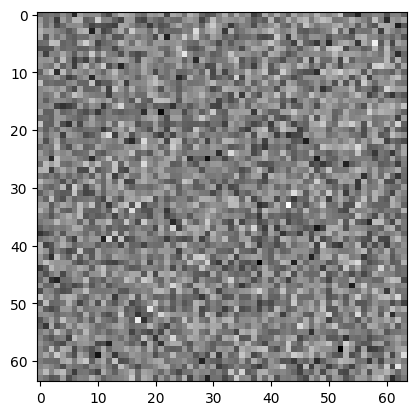

In [116]:
# Stepping through `nn.Conv2d()`

# create a batch of "images" .. aka data that look like the image tensor
X_batch = torch.randn(size=(32, 3, 64, 64)).to(device) # (batch_size, color_channels, height, width)
test_image = X_batch[0][0]
plt.imshow(test_image.squeeze(), cmap="binary")

torch.Size([10, 62, 62])


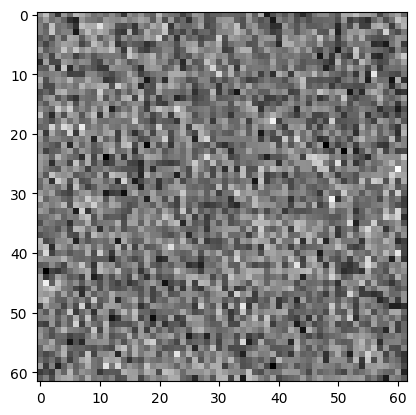

In [117]:
test_2d = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
test_2d_output = test_2d(X_batch[0])
print(test_2d_output.shape)
plt.imshow(test_2d_output[0].detach().squeeze(), cmap="binary")

torch.Size([10, 31, 31])


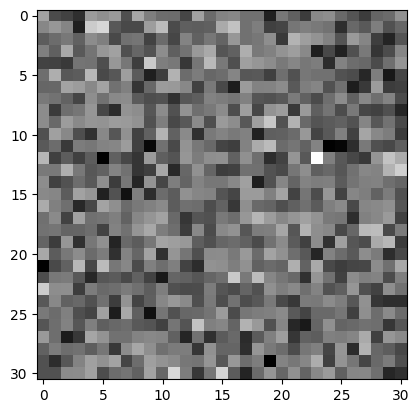

In [118]:
# Create a sample of max poul layer
test_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
test_maxpool_output = test_maxpool(test_2d_output)
print(test_maxpool_output.shape)
plt.imshow(test_maxpool_output[0].detach().squeeze(), cmap="binary")

Set up loss and optimizer

In [119]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=LEARNING_RATE)

In [120]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# start timer
start_time = timer()

# build train and test loop
for epoch in tqdm(range(NUM_EPOCHS)):
  print(f"Epoch: {epoch}")
  train_step(
    model=model_1,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn,
    device=device
  )
  test_step(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
  )

# end timer
end_time = timer()

# print the train time
print_train_time(start_time, end_time, device=device)



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Batch: 0 | Train loss: 0.0012 | Train acc: 0.0033
Batch: 1 | Train loss: 0.0025 | Train acc: 0.0083
Batch: 2 | Train loss: 0.0037 | Train acc: 0.0167
Batch: 3 | Train loss: 0.0049 | Train acc: 0.0217
Batch: 4 | Train loss: 0.0061 | Train acc: 0.0250
Batch: 5 | Train loss: 0.0074 | Train acc: 0.0350
Batch: 6 | Train loss: 0.0086 | Train acc: 0.0400
Batch: 7 | Train loss: 0.0098 | Train acc: 0.0517
Batch: 8 | Train loss: 0.0110 | Train acc: 0.0567
Batch: 9 | Train loss: 0.0123 | Train acc: 0.0633
Batch: 10 | Train loss: 0.0135 | Train acc: 0.0700
Batch: 11 | Train loss: 0.0147 | Train acc: 0.0783
Batch: 12 | Train loss: 0.0159 | Train acc: 0.0800
Batch: 13 | Train loss: 0.0171 | Train acc: 0.0883
Batch: 14 | Train loss: 0.0184 | Train acc: 0.0983
Batch: 15 | Train loss: 0.0196 | Train acc: 0.1067
Batch: 16 | Train loss: 0.0208 | Train acc: 0.1133
Batch: 17 | Train loss: 0.0220 | Train acc: 0.1250
Batch: 18 | Train loss: 0.0232 | Train acc: 0.1467
Batch: 19 | Train loss: 0.0244 |

KeyboardInterrupt: 